In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
images_fol = "/content/drive/MyDrive/leaf_disease_dataset/aug_data/images"
masks_fol = "/content/drive/MyDrive/leaf_disease_dataset/aug_data/masks"
dataset_path = "/content/drive/MyDrive/leaf_disease_dataset/aug_data"

In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [4]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))   
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

""" Hyperparameters """
batch_size = 15
lr = 1e-5
num_epochs = 20
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

""" Dataset """
# dataset_path = images_fol
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

""" Model """
model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path)
]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Train: 2352 - 2352
Valid: 294 - 294
Test: 294 - 294
Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.6079 - dice_coef: 0.3922 - iou: 0.2482 - recall: 0.7540 - precision: 0.3392
Epoch 1: val_loss improved from inf to 0.82355, saving model to files/model.h5
157/157 [==============================] - 1772s 11s/step - loss: 0.6079 - dice_coef: 0.3922 - iou: 0.2482 - recall: 0.7540 - precision: 0.3392 - val_loss: 0.8236 - val_dice_coef: 0.1776 - val_iou: 0.0976 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.4788 - dice_coef: 0.5213 - iou: 0.3564 - recall: 0.8150 - precision: 0.4781
Epoch 2: val_loss did not improve from 0.82355
157/157 [==============================] - 133s 845ms/step - loss: 0.4788 - dice_coef: 0.5213 - iou: 0.3564 - recall: 0.8150 - precision: 0.4781 - val_loss: 0.8585 - val_dice_coef: 0.1409 - val_iou: 0.0762 - val_recall: 0.0252 - val_precision: 0.8065 

In [7]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope

H = 256
W = 256

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("results")

""" Loading model """
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
#  model = tf.keras.models.load_model("files/model.h5")

# (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

""" Predicting the mask """
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracing the image name. """
    image_name = x.split("/")[-1]

    """ Reading the image """
    ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W, H))
    x = ori_x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    """ Reading the mask """
    ori_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    ori_y = cv2.resize(ori_y, (W, H))
    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (256, 256, 3)

    """ Predicting the mask. """
    y_pred = model.predict(x)[0] > 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the predicted mask along with the image and GT """
    save_image_path = f"results/{image_name}"
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    sep_line = np.ones((H, 10, 3)) * 255

    cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_image)

  0%|          | 0/294 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/294 [00:02<11:56,  2.45s/it]

1/1 [==============================] - 0s 16ms/step


  1%|          | 2/294 [00:03<07:07,  1.47s/it]

1/1 [==============================] - 0s 17ms/step


  1%|          | 3/294 [00:03<05:11,  1.07s/it]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 4/294 [00:04<04:23,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 5/294 [00:05<04:58,  1.03s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 6/294 [00:06<04:23,  1.09it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 7/294 [00:07<04:32,  1.05it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 8/294 [00:08<04:17,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 9/294 [00:09<04:14,  1.12it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 10/294 [00:09<03:51,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 11/294 [00:10<03:36,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 12/294 [00:11<03:24,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 13/294 [00:11<03:15,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 14/294 [00:12<03:22,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 15/294 [00:13<03:36,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 16/294 [00:14<03:26,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 17/294 [00:14<03:15,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 18/294 [00:15<03:09,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 19/294 [00:15<03:04,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 20/294 [00:16<03:00,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 21/294 [00:17<02:56,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 22/294 [00:17<03:07,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 23/294 [00:18<03:27,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 24/294 [00:19<03:14,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 25/294 [00:20<03:08,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 26/294 [00:20<03:01,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 27/294 [00:21<03:28,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 28/294 [00:22<03:30,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 29/294 [00:23<03:40,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 30/294 [00:24<03:40,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 31/294 [00:25<03:53,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 32/294 [00:26<03:51,  1.13it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 33/294 [00:27<03:44,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 34/294 [00:27<03:26,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 35/294 [00:28<03:12,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 36/294 [00:28<03:02,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 37/294 [00:29<02:58,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 38/294 [00:30<03:09,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 39/294 [00:31<03:06,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 40/294 [00:31<02:58,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 41/294 [00:32<02:52,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 42/294 [00:33<02:47,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 43/294 [00:33<02:45,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 44/294 [00:34<03:04,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 45/294 [00:35<03:10,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 46/294 [00:36<03:11,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 47/294 [00:36<02:59,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 48/294 [00:37<03:15,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 49/294 [00:38<03:11,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 50/294 [00:39<03:11,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 51/294 [00:40<03:00,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 52/294 [00:40<02:52,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 53/294 [00:41<02:57,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 54/294 [00:42<02:50,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 55/294 [00:42<02:45,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 56/294 [00:43<02:52,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 57/294 [00:44<02:45,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 58/294 [00:44<02:44,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 59/294 [00:45<02:42,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 60/294 [00:46<02:50,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 61/294 [00:47<03:00,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 62/294 [00:47<02:49,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 63/294 [00:48<02:41,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 64/294 [00:49<02:36,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 65/294 [00:49<02:32,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 66/294 [00:50<02:29,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 67/294 [00:51<02:27,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 68/294 [00:51<02:24,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 69/294 [00:52<02:29,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 70/294 [00:53<02:27,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 71/294 [00:53<02:25,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 72/294 [00:54<02:24,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 73/294 [00:54<02:23,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 74/294 [00:55<02:34,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 75/294 [00:56<02:28,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 76/294 [00:57<02:22,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 77/294 [00:57<02:30,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 78/294 [00:58<02:26,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 79/294 [00:59<02:27,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 80/294 [01:00<03:03,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 81/294 [01:01<03:26,  1.03it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 82/294 [01:02<03:12,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 83/294 [01:03<03:04,  1.14it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 84/294 [01:04<03:02,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 85/294 [01:04<02:49,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 86/294 [01:05<02:45,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 87/294 [01:06<02:39,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 88/294 [01:06<02:30,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 89/294 [01:07<02:46,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 90/294 [01:08<02:42,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 91/294 [01:09<02:49,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 92/294 [01:10<02:51,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 93/294 [01:11<02:54,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 94/294 [01:11<02:39,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 95/294 [01:12<02:32,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 96/294 [01:13<02:23,  1.38it/s]

1/1 [==============================] - 0s 75ms/step


 33%|███▎      | 97/294 [01:14<02:26,  1.34it/s]

1/1 [==============================] - 0s 98ms/step


 33%|███▎      | 98/294 [01:14<02:34,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 99/294 [01:15<02:36,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 100/294 [01:16<02:25,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 101/294 [01:17<02:19,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 102/294 [01:17<02:12,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 103/294 [01:18<02:09,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 104/294 [01:18<02:03,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 105/294 [01:19<02:01,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 106/294 [01:20<01:59,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 107/294 [01:20<01:58,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 108/294 [01:21<02:16,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 109/294 [01:22<02:10,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 110/294 [01:23<02:10,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 111/294 [01:23<02:05,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 112/294 [01:24<02:05,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 113/294 [01:25<02:09,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 114/294 [01:25<02:03,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 115/294 [01:26<02:00,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 116/294 [01:27<01:58,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 117/294 [01:28<02:08,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 118/294 [01:28<02:04,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 119/294 [01:29<02:01,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 120/294 [01:30<02:04,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 121/294 [01:30<01:59,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 122/294 [01:31<02:05,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 123/294 [01:32<01:59,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 124/294 [01:32<01:55,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 125/294 [01:33<01:54,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 126/294 [01:34<01:53,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 127/294 [01:34<02:00,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 128/294 [01:35<02:01,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 129/294 [01:36<02:03,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 130/294 [01:37<01:59,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 131/294 [01:37<02:01,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 132/294 [01:38<01:56,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 133/294 [01:39<01:52,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 134/294 [01:39<01:50,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 135/294 [01:40<01:54,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 136/294 [01:41<01:50,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 137/294 [01:42<01:46,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 138/294 [01:42<01:45,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 139/294 [01:43<01:56,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 140/294 [01:44<01:50,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 141/294 [01:44<01:47,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 142/294 [01:45<01:42,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 143/294 [01:46<01:39,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 144/294 [01:46<01:38,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 145/294 [01:47<01:35,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 146/294 [01:48<01:33,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 147/294 [01:48<01:40,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 148/294 [01:49<01:38,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 149/294 [01:50<01:39,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 150/294 [01:51<01:49,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 151/294 [01:51<01:50,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 152/294 [01:52<01:44,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 153/294 [01:53<01:46,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 154/294 [01:54<01:40,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 155/294 [01:54<01:36,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 156/294 [01:55<01:43,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 157/294 [01:56<01:36,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 158/294 [01:56<01:33,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 159/294 [01:57<01:30,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 160/294 [01:58<01:27,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 161/294 [01:58<01:27,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 162/294 [01:59<01:31,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 163/294 [02:00<01:39,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 164/294 [02:01<01:41,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 165/294 [02:01<01:35,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 166/294 [02:02<01:31,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 167/294 [02:03<01:35,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 168/294 [02:04<01:30,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 169/294 [02:04<01:27,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 170/294 [02:05<01:24,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 171/294 [02:05<01:21,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 172/294 [02:06<01:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 173/294 [02:07<01:18,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 174/294 [02:07<01:17,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 175/294 [02:08<01:17,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 176/294 [02:09<01:18,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 177/294 [02:09<01:18,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 178/294 [02:10<01:21,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 179/294 [02:11<01:18,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 180/294 [02:12<01:21,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 181/294 [02:12<01:25,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 182/294 [02:13<01:20,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 183/294 [02:14<01:16,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 184/294 [02:15<01:24,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 185/294 [02:15<01:20,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 186/294 [02:16<01:16,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 187/294 [02:17<01:19,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 188/294 [02:18<01:20,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 189/294 [02:18<01:14,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 190/294 [02:19<01:11,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 191/294 [02:19<01:09,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 192/294 [02:20<01:16,  1.33it/s]

1/1 [==============================] - 0s 74ms/step


 66%|██████▌   | 193/294 [02:21<01:14,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 194/294 [02:22<01:20,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 195/294 [02:23<01:19,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 196/294 [02:23<01:13,  1.34it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 197/294 [02:24<01:15,  1.28it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 198/294 [02:25<01:16,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 199/294 [02:26<01:21,  1.16it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 200/294 [02:27<01:16,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 201/294 [02:28<01:12,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 202/294 [02:28<01:12,  1.26it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 203/294 [02:29<01:10,  1.30it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 204/294 [02:30<01:10,  1.27it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 205/294 [02:31<01:08,  1.29it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 206/294 [02:31<01:06,  1.33it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 207/294 [02:32<01:04,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 208/294 [02:33<01:02,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 209/294 [02:34<01:02,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 210/294 [02:34<01:00,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 211/294 [02:35<01:04,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 212/294 [02:36<01:01,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 213/294 [02:37<01:01,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 214/294 [02:37<00:57,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 215/294 [02:38<00:55,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 216/294 [02:39<01:00,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 217/294 [02:40<01:05,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 218/294 [02:41<01:03,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 219/294 [02:41<00:57,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 220/294 [02:42<00:54,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 221/294 [02:43<00:54,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 222/294 [02:43<00:51,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 223/294 [02:44<00:55,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 224/294 [02:45<00:52,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 225/294 [02:46<00:48,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 226/294 [02:46<00:47,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 227/294 [02:47<00:45,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 228/294 [02:48<00:44,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 229/294 [02:48<00:44,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 230/294 [02:49<00:42,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 231/294 [02:50<00:44,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 232/294 [02:50<00:43,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 233/294 [02:51<00:44,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 234/294 [02:52<00:45,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 235/294 [02:53<00:42,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 236/294 [02:53<00:40,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 237/294 [02:54<00:39,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 238/294 [02:55<00:40,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 239/294 [02:55<00:38,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 240/294 [02:56<00:36,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 241/294 [02:57<00:35,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 242/294 [02:57<00:34,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 243/294 [02:58<00:36,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 244/294 [02:59<00:45,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 245/294 [03:00<00:42,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 246/294 [03:01<00:38,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 247/294 [03:02<00:35,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 248/294 [03:02<00:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 249/294 [03:03<00:34,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 250/294 [03:04<00:33,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 251/294 [03:05<00:31,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 252/294 [03:05<00:31,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 253/294 [03:06<00:29,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 254/294 [03:07<00:29,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 255/294 [03:07<00:27,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 256/294 [03:08<00:27,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 257/294 [03:09<00:25,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 258/294 [03:10<00:25,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 259/294 [03:10<00:26,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 260/294 [03:11<00:27,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 261/294 [03:12<00:24,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 262/294 [03:13<00:23,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 263/294 [03:13<00:22,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 264/294 [03:14<00:23,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 265/294 [03:15<00:23,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 266/294 [03:16<00:22,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 267/294 [03:17<00:20,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 268/294 [03:17<00:20,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 269/294 [03:19<00:26,  1.04s/it]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 270/294 [03:20<00:23,  1.02it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 271/294 [03:21<00:21,  1.08it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 272/294 [03:21<00:18,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 273/294 [03:22<00:16,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 274/294 [03:23<00:16,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 275/294 [03:24<00:14,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 276/294 [03:24<00:13,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 277/294 [03:25<00:12,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 278/294 [03:26<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 279/294 [03:26<00:11,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 280/294 [03:27<00:09,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 281/294 [03:28<00:08,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 282/294 [03:29<00:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 283/294 [03:29<00:07,  1.38it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 284/294 [03:30<00:07,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 285/294 [03:31<00:06,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 286/294 [03:31<00:05,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 287/294 [03:32<00:05,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 288/294 [03:33<00:04,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 289/294 [03:33<00:03,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 290/294 [03:34<00:03,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 291/294 [03:35<00:02,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 292/294 [03:36<00:01,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 293/294 [03:37<00:00,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 294/294 [03:37<00:00,  1.35it/s]


In [8]:
! ls results 

00003_0.jpg  00103_1.jpg  00177_3.jpg  00276_1.jpg  00370_4.jpg  00486_2.jpg
00004_0.jpg  00103_3.jpg  00178_3.jpg  00280_0.jpg  00372_3.jpg  00487_4.jpg
00005_2.jpg  00107_4.jpg  00182_0.jpg  00280_3.jpg  00373_0.jpg  00488_0.jpg
00005_3.jpg  00109_3.jpg  00183_1.jpg  00281_4.jpg  00376_2.jpg  00489_2.jpg
00011_0.jpg  00110_2.jpg  00184_1.jpg  00282_4.jpg  00379_2.jpg  00493_2.jpg
00015_3.jpg  00110_3.jpg  00186_3.jpg  00288_0.jpg  00388_3.jpg  00494_1.jpg
00019_2.jpg  00112_1.jpg  00187_3.jpg  00290_2.jpg  00389_3.jpg  00497_2.jpg
00024_1.jpg  00114_0.jpg  00188_2.jpg  00291_1.jpg  00393_0.jpg  00499_4.jpg
00026_0.jpg  00115_0.jpg  00188_4.jpg  00291_3.jpg  00393_2.jpg  00501_4.jpg
00027_1.jpg  00115_2.jpg  00189_1.jpg  00294_0.jpg  00393_4.jpg  00504_4.jpg
00028_2.jpg  00115_3.jpg  00191_3.jpg  00299_3.jpg  00394_4.jpg  00510_3.jpg
00029_0.jpg  00118_0.jpg  00194_1.jpg  00299_4.jpg  00395_2.jpg  00510_4.jpg
00033_2.jpg  00118_4.jpg  00194_3.jpg  00300_3.jpg  00398_0.jpg  00511_3.jpg

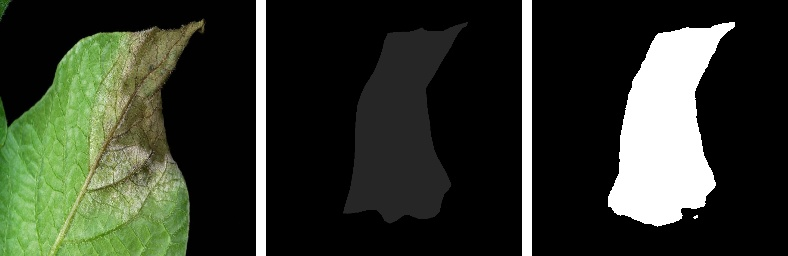

In [16]:
from google.colab.patches import cv2_imshow
path = "results/00011_0.jpg"
img = cv2.imread(path)

cv2_imshow(img)